# Linear Regression Models

## Packages and Configs

In [263]:
import pickle
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [264]:
#Setup Configs
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

## Data Import

In [435]:
def from_pickle(fp):
    with open(fp, 'rb') as to_read: 
        return pickle.load(to_read)
    return None

def table_clean(df):
    df = df[df['purpose'] == 'Initial Potential']
    df = df.dropna(subset=['api_num'])
    df['api_num'] = df['api_num'].apply(lambda x: int(''.join(x.split('-'))+'0000'))
    df['ip24_gas'] = df['ip24_gas'].apply(pd.to_numeric, errors='coerce')
    df['ip24_oil'] = df['ip24_oil'].apply(pd.to_numeric, errors='coerce')
    df['pressure'] = df['pressure'].apply(pd.to_numeric, errors='coerce')
    df['ip24_water'] = df['ip24_water'].apply(pd.to_numeric, errors='coerce')
    df['ll'] = df['ll'].apply(pd.to_numeric, errors='coerce')
    df['md'] = df['md'].apply(pd.to_numeric, errors='coerce')
    df['tvd'] = df['tvd'].apply(pd.to_numeric, errors='coerce')
    df['ll'] = df['ll'].fillna(df['md'] - df['tvd'])
    df = df.dropna()
    df_out = df[['api_num','ip24_oil','ip24_gas','ip24_water','ll','tvd','pressure','comp_type','test_method']]
    return df_out

In [419]:
chem_sandtype = from_pickle('pickle/chem_sandtype.pickle')
chem_sandmesh = from_pickle('pickle/chem_sandmesh.pickle')
chem_purpose = from_pickle('pickle/chem_purpose.pickle')
midland_wells_narrow = from_pickle('pickle/midland_narrow.pickle')   #pickle/ef_all.pickle  #pickle/midland_narrow.pickle
midland_wells_narrow = midland_wells_narrow[['APINumber','JobStartDate','CountyNumber',
                        'Latitude','Longitude','TotalBaseWaterVolume',
                        'TotalBaseNonWaterVolume']]

ef_wells = from_pickle('pickle/ef_all.pickle')
ef_wells = midland_wells_narrow[['APINumber','JobStartDate','CountyNumber',
                        'Latitude','Longitude','TotalBaseWaterVolume',
                        'TotalBaseNonWaterVolume']]

midland_all = from_pickle('pickle/midland_all.pickle')
midland_all = midland_all[['APINumber','JobStartDate','CountyNumber',
                        'Latitude','Longitude','TotalBaseWaterVolume',
                        'TotalBaseNonWaterVolume']]

## Dataset Merge

In [267]:
def merge_on_first(df1,df_list):
    '''
    Designed to merge the chem tables with the pdf scraped well lists
    '''
    for df in df_list:
        df1 = pd.merge(df1,df,how='left',left_on='api_num',right_on='APINumber').drop(['APINumber'],axis=1)
        df1 = df1.dropna()
    return df1

In [268]:
from_pickle('pickle/ef_pdfs.pickle').sample(5)

,api_num,choke,comp_date,comp_type,ip24_gas,ip24_oil,ip24_water,ll,md,pressure,purpose,test_date,test_method,tvd,well_type
1404,42-255-35652,Oil produced prior to test:,10/19/2017,Other/Recompletion,Casing Pressure:,Oil Gravity - API - 60.:,None,NaN,Plug back depth TVD (ft.):,NaN,Well Record Only,None,Choke size:,Total depth MD (ft.):,Producing
867,42-255-36069,56/64,07/16/2018,New Well,3070,2322.0,3214,4256.0,14892,3300.0,Initial Potential,04/29/2019,Flowing,10334,Producing
1241,42-255-34792,12 6/4,10/07/2015,Other/Recompletion,725,1032.0,322,4731.0,16232,1500.0,Initial Potential,01/16/2017,Flowing,11024,Producing
293,42-255-34597,4/64,05/22/2015,New Well,1372,1071.0,124,4151.0,14955,3352.0,Initial Potential,02/08/2017,Flowing,10331,Producing
1603,42-255-34602,Oil produced prior to test:,09/18/2015,New Well,Casing Pressure:,Oil Gravity - API - 60.:,None,NaN,15895,2865.0,Well Record Only,None,Choke size:,10177,Shut-In Producer


In [269]:
yx_raw = merge_on_first(table_clean(from_pickle('pickle/n_midland_pdfs.pickle').dropna(subset=['api_num'])),
                        [midland_wells_narrow,chem_sandtype,chem_sandmesh,chem_purpose])

# pickle/ef_pdfs.pickle
# pickle/n_midland_pdfs.pickle

/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [270]:
len(yx_raw)

342

In [271]:
yx_raw.head()

,api_num,ip24_oil,ip24_gas,ip24_water,ll,tvd,pressure,comp_type,test_method,JobStartDate,CountyNumber,Latitude,Longitude,TotalBaseWaterVolume,TotalBaseNonWaterVolume,ceramic,rcs,sand,100-mesh,12/20,16/30,20/40,30/50,40/140,40/70,other,acid,biocide,clay,corrosion,friction,gel,iron,surfactant
0,42227395770000,1073.0,589,311.0,7172.0,8426,9390.0,New Well,Pumping,2018-10-07 02:01:00,227.0,32.477,-101.680,1.400e+07,0.0,0.0,0.0,9.887,0.00,0.000,0.0,0.0,0.0,0.0,0.0,9.887,0.080,0.008,0.000,0.000e+00,0.019,0.000,3.374e-03,0.004
1,42227391820000,665.3,559,875.0,9251.0,7909,9212.0,New Well,Pumping,2018-02-18 06:00:00,227.0,32.432,-101.577,1.300e+07,0.0,0.0,0.0,15.226,0.00,0.000,0.0,0.0,0.0,0.0,0.0,15.226,0.215,0.000,0.000,1.839e-04,0.012,0.322,1.546e-03,0.098
2,42227383850000,808.0,613,911.0,4906.0,7586,3273.0,New Well,Pumping,2015-05-26 12:00:00,227.0,32.296,-101.637,5.072e+06,0.0,0.0,0.0,100.001,0.00,100.001,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000e+00,100.001,0.000,0.000e+00,0.000
3,42227388850000,932.0,783,4223.0,7828.0,7288,9157.0,Other/Recompletion,Pumping,2017-04-09 07:45:00,227.0,32.343,-101.547,1.903e+07,0.0,0.0,0.0,8.386,0.00,0.000,0.0,0.0,0.0,0.0,0.0,8.386,0.142,0.037,0.045,3.223e-04,0.038,0.011,4.481e-04,0.100
4,42227394150000,464.0,393,1334.0,6958.0,7713,8875.0,New Well,Pumping,2018-04-03 05:00:00,227.0,32.423,-101.610,7.839e+06,0.0,0.0,0.0,13.130,13.13,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.244,0.000,0.002,4.797e-04,0.039,0.000,1.048e-03,0.000


In [272]:
yx_raw.describe()

,api_num,ip24_oil,ip24_gas,ip24_water,ll,tvd,pressure,CountyNumber,Latitude,Longitude,TotalBaseWaterVolume,TotalBaseNonWaterVolume,ceramic,rcs,sand,100-mesh,12/20,16/30,20/40,30/50,40/140,40/70,other,acid,biocide,clay,corrosion,friction,gel,iron,surfactant
count,3.420e+02,342.000,342.000,342.000,342.000,342.000,342.000,342.000,342.000,342.000,3.420e+02,3.420e+02,342.0,342.000,342.000,342.000,342.000,342.0,342.0,342.000,342.0,342.000,342.000,342.000,342.000,342.000,3.420e+02,342.000,342.000,3.420e+02,3.420e+02
mean,4.223e+13,1034.908,742.795,1686.231,8072.161,7980.442,8435.278,233.316,32.389,-101.612,1.565e+07,2.292e+04,0.0,0.212,10.473,1.663,0.585,0.0,0.0,0.153,0.0,1.946,6.338,0.322,0.003,0.020,6.318e-04,0.630,0.040,1.732e-03,3.740e-02
std,2.303e+10,421.457,368.677,858.086,1996.463,399.260,2226.173,23.024,0.060,0.059,8.865e+06,1.097e+05,0.0,0.560,9.527,3.645,7.636,0.0,0.0,1.040,0.0,4.976,5.687,0.347,0.009,0.040,1.792e-03,7.633,0.078,1.866e-03,6.099e-02
min,4.223e+13,56.000,0.000,0.000,11.000,6907.000,1251.000,227.000,32.277,-101.766,0.000e+00,0.000e+00,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000e+00,0.000,0.000,0.000e+00,0.000e+00
25%,4.223e+13,718.250,466.750,1080.250,6943.250,7743.000,8241.250,227.000,32.346,-101.658,1.123e+07,0.000e+00,0.0,0.000,8.483,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.040,0.000,0.000,1.819e-04,0.015,0.000,3.019e-04,0.000e+00
50%,4.223e+13,1005.500,675.500,1542.000,7672.500,7954.500,9014.000,227.000,32.409,-101.615,1.443e+07,0.000e+00,0.0,0.000,9.857,0.000,0.000,0.0,0.0,0.000,0.0,0.000,8.233,0.285,0.000,0.000,3.045e-04,0.026,0.000,1.318e-03,2.092e-04
75%,4.223e+13,1248.750,949.500,2188.750,9738.250,8207.750,9306.500,227.000,32.440,-101.559,1.828e+07,0.000e+00,0.0,0.000,12.176,1.698,0.000,0.0,0.0,0.000,0.0,0.000,10.462,0.436,0.001,0.045,4.314e-04,0.066,0.054,2.616e-03,8.695e-02
max,4.232e+13,2386.000,2015.000,6807.000,12947.000,9794.000,12024.000,317.000,32.483,-101.517,1.437e+08,1.021e+06,0.0,6.474,100.001,25.597,100.001,0.0,0.0,11.223,0.0,63.880,26.122,2.686,0.072,0.417,2.184e-02,100.001,0.535,1.709e-02,4.290e-01


## Data Cleanup

In [273]:
def convert_to_bool(df,percentile=.5):
    for column in df.columns:
        if np.issubdtype(df[column].dtype, np.number):
            if df[column].quantile(percentile) == 0:
                df[column] = df[column].astype('bool')
                df = df.rename(columns={column : column + "-bool"})
    return df    

def convert_all_dummies(df):
    df = pd.get_dummies(df,columns=df.select_dtypes(include='object').columns)
    return df 

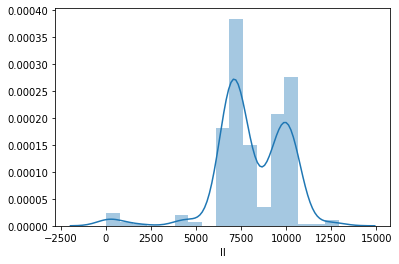

In [274]:
sns.distplot(yx_raw['ll'])

In [275]:
yx_raw.head()

,api_num,ip24_oil,ip24_gas,ip24_water,ll,tvd,pressure,comp_type,test_method,JobStartDate,CountyNumber,Latitude,Longitude,TotalBaseWaterVolume,TotalBaseNonWaterVolume,ceramic,rcs,sand,100-mesh,12/20,16/30,20/40,30/50,40/140,40/70,other,acid,biocide,clay,corrosion,friction,gel,iron,surfactant
0,42227395770000,1073.0,589,311.0,7172.0,8426,9390.0,New Well,Pumping,2018-10-07 02:01:00,227.0,32.477,-101.680,1.400e+07,0.0,0.0,0.0,9.887,0.00,0.000,0.0,0.0,0.0,0.0,0.0,9.887,0.080,0.008,0.000,0.000e+00,0.019,0.000,3.374e-03,0.004
1,42227391820000,665.3,559,875.0,9251.0,7909,9212.0,New Well,Pumping,2018-02-18 06:00:00,227.0,32.432,-101.577,1.300e+07,0.0,0.0,0.0,15.226,0.00,0.000,0.0,0.0,0.0,0.0,0.0,15.226,0.215,0.000,0.000,1.839e-04,0.012,0.322,1.546e-03,0.098
2,42227383850000,808.0,613,911.0,4906.0,7586,3273.0,New Well,Pumping,2015-05-26 12:00:00,227.0,32.296,-101.637,5.072e+06,0.0,0.0,0.0,100.001,0.00,100.001,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000e+00,100.001,0.000,0.000e+00,0.000
3,42227388850000,932.0,783,4223.0,7828.0,7288,9157.0,Other/Recompletion,Pumping,2017-04-09 07:45:00,227.0,32.343,-101.547,1.903e+07,0.0,0.0,0.0,8.386,0.00,0.000,0.0,0.0,0.0,0.0,0.0,8.386,0.142,0.037,0.045,3.223e-04,0.038,0.011,4.481e-04,0.100
4,42227394150000,464.0,393,1334.0,6958.0,7713,8875.0,New Well,Pumping,2018-04-03 05:00:00,227.0,32.423,-101.610,7.839e+06,0.0,0.0,0.0,13.130,13.13,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.244,0.000,0.002,4.797e-04,0.039,0.000,1.048e-03,0.000


In [276]:
yx_live = yx_raw.copy(deep=True)
yx_live['total_base_vol'] = (yx_live['TotalBaseWaterVolume'] + yx_live['TotalBaseNonWaterVolume']) / yx_live['ll']
yx_live['water_vol'] = yx_live['TotalBaseWaterVolume'] / yx_live['ll'] / yx_live['total_base_vol']
yx_live['prop_total'] = yx_live['sand'] + yx_live['rcs']
yx_live['prop_total'] = (yx_live[['prop_total','total_base_vol']]
                         .apply(lambda row: (8.345404*row['prop_total']*row['total_base_vol']/100),axis=1))
yx_live = yx_live.drop(['TotalBaseWaterVolume','TotalBaseNonWaterVolume'],axis=1)
yx_live = convert_all_dummies(yx_live)
yx_live['ip24_boe'] = yx_live['ip24_oil'] + yx_live['ip24_gas'] / 6
for rate in ['ip24_oil','ip24_gas','ip24_water','ip24_boe']:
    yx_live[rate] = yx_live[rate] / yx_live['ll']

yx_live = yx_live[((yx_live['prop_total'] < 4000) &
              (yx_live['prop_total'] > 100) &
              (yx_live['total_base_vol'] < 4000) &
              (yx_live['total_base_vol'] > 100) &
              (yx_live['ll'] >= 5000) &
              (yx_live['ll'] <= 12500))]
yx_live = convert_to_bool(yx_live)


yx_live.sample(10)

,api_num,ip24_oil,ip24_gas,ip24_water,ll,tvd,pressure,JobStartDate,CountyNumber,Latitude,Longitude,ceramic-bool,rcs-bool,sand,100-mesh-bool,12/20-bool,16/30-bool,20/40-bool,30/50-bool,40/140-bool,40/70-bool,other,acid,biocide-bool,clay-bool,corrosion,friction,gel,iron,surfactant,total_base_vol,water_vol,prop_total,comp_type_New Well,comp_type_Other/Recompletion-bool,test_method_Flowing-bool,test_method_Gas Lift-bool,test_method_Pumping,ip24_boe
258,42227389060000,0.103,0.103,0.091,6791.0,7887,9164.0,2017-02-19 06:00:00,227.0,32.429,-101.553,False,True,11.271,True,False,False,False,False,False,True,0.830,0.348,True,True,2.548e-04,0.089,5.869e-02,3.188e-03,0.000e+00,1765.039,1.0,1782.514,1,False,False,False,1,0.120
187,42227390390000,0.047,0.063,0.064,7654.0,8468,9557.0,2017-11-27 12:00:00,227.0,32.312,-101.607,False,False,10.476,False,False,False,False,False,False,False,10.476,0.362,False,False,3.096e-04,0.022,9.432e-02,2.603e-03,2.191e-04,1854.448,1.0,1621.243,1,False,False,True,0,0.057
247,42227391340000,0.183,0.066,0.240,7369.0,8250,8880.0,2017-10-12 12:00:00,227.0,32.472,-101.630,False,False,9.677,False,False,False,False,False,False,False,9.677,0.666,True,False,5.692e-04,0.050,0.000e+00,4.790e-03,4.047e-04,2312.958,1.0,1867.814,1,False,False,False,1,0.194
47,42227392410000,0.140,0.067,0.110,6921.0,8111,8989.0,2017-11-20 06:00:00,227.0,32.451,-101.626,False,False,14.358,False,False,False,False,False,False,False,14.358,0.399,False,False,3.421e-04,0.072,0.000e+00,2.869e-03,8.817e-02,1502.406,1.0,1800.192,1,False,False,False,1,0.152
14,42227381070000,0.096,0.073,0.087,7773.0,7793,3341.0,2014-12-16 12:00:00,227.0,32.329,-101.534,False,False,20.021,True,False,False,False,True,False,True,0.000,1.331,False,True,1.381e-03,0.019,1.207e-01,6.086e-03,1.051e-01,1314.541,1.0,2196.421,1,False,True,False,0,0.108
230,42227396680000,0.145,0.072,0.329,7070.0,7938,9013.0,2018-09-18 05:00:00,227.0,32.424,-101.579,False,False,13.455,True,False,False,False,False,False,False,0.000,0.187,False,False,9.350e-05,0.023,0.000e+00,2.570e-04,0.000e+00,1674.350,1.0,1880.102,1,False,False,False,1,0.157
267,42227394760000,0.131,0.117,0.206,10465.0,8206,9340.0,2018-09-30 05:00:00,227.0,32.347,-101.626,False,False,9.914,False,False,False,False,False,False,False,9.914,0.095,True,False,1.887e-04,0.043,9.530e-04,5.009e-04,9.833e-02,2036.340,1.0,1684.868,0,True,False,False,1,0.151
10,42317410610000,0.171,0.108,0.215,7093.0,8652,8188.0,2018-10-03 12:00:00,317.0,32.441,-101.734,False,False,9.051,True,False,False,False,False,False,True,0.000,1.192,True,False,6.914e-03,0.023,0.000e+00,0.000e+00,8.221e-02,1929.167,1.0,1457.190,1,False,True,False,0,0.189
255,42227394800000,0.138,0.083,0.215,10452.0,7970,9138.0,2018-09-07 05:00:00,227.0,32.347,-101.626,False,False,9.412,False,False,False,False,False,False,False,9.412,0.029,True,False,5.708e-05,0.025,0.000e+00,1.515e-04,9.981e-02,2129.165,1.0,1672.433,0,True,False,False,1,0.152
36,42227390310000,0.066,0.047,0.157,9267.0,8102,9086.0,2017-06-14 05:00:00,227.0,32.434,-101.564,False,False,8.493,False,False,False,False,False,False,False,8.493,0.560,False,False,4.780e-04,0.046,0.000e+00,4.023e-03,9.263e-02,2484.898,1.0,1761.254,1,False,False,False,1,0.073


## Model Tests

In [366]:
def split_and_validate(X,y,split=0.2,random_state=None,model_obj=LinearRegression(),scale=False):
    #perform train/val split
    X_train, X_val ,y_train, y_val = \
        train_test_split(X,y,test_size=split,random_state=random_state)
    
    #fit linear regression to training data
    model = model_obj
    
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
    
    model.fit(X_train,y_train)
    
    #score fit model on validation data
    val_r2 = r2_score(y_val,model.predict(X_val))
    train_r2 = r2_score(y_train,model.predict(X_train))
    val_mse = np.sqrt(mean_squared_error(y_val,model.predict(X_val)))
    coef = model.coef_

    return {'val_r2' : val_r2, 'train_r2' : train_r2, 'val_mse' : val_mse, 'coef' : coef}

In [367]:
def test_loop(X,y,loops,split=.2,model_obj=LinearRegression(),scale=False):
    val_r2_list = []
    train_r2_list = []
    val_mse_list = []

    for _ in range(0,loops):
        rs = split_and_validate(X,y,split=split,model_obj=model_obj,scale=scale)
        val_r2_list.append(rs['val_r2'])
        train_r2_list.append(rs['train_r2'])
        val_mse_list.append(rs['val_mse'])
        
    val_r2_mean = np.mean(val_r2_list)
    train_r2_mean = np.mean(train_r2_list)
    val_mse_mean = np.mean(val_mse_list)
        
    return [val_r2_mean,train_r2_mean,val_mse_mean]

### All Variables LinReg

In [324]:
X = yx_live.drop(['api_num','ip24_oil','ip24_gas',
                  'ip24_water','JobStartDate','CountyNumber',
                  'Latitude','Longitude','ip24_boe','sand'],axis=1)

In [325]:
y = np.log(yx_live['ip24_boe'])
test_loop(X,y,2000)

[0.00904781857455077, 0.2694907273280838, 0.379772621751846]

In [326]:
y = yx_live['ip24_boe']
test_loop(X,y,2000)

[0.01806431037957379, 0.2692182318360452, 0.04846113354126478]

### Limited Variable LinReg

In [327]:
X = yx_live[['ll','pressure','total_base_vol','water_vol','prop_total']]

y = yx_live['ip24_boe']

yX = pd.concat([y,X],axis=1).reindex(y.index)

In [328]:
#sns.pairplot(yX)

In [329]:
y = np.log(yx_live['ip24_boe'])
test_loop(X,y,2000)

[0.009549625627256045, 0.0817358578581555, 0.3813668938468172]

In [330]:
y = yx_live['ip24_boe']
test_loop(X,y,2000)

[0.00572943194573667, 0.08896125118486034, 0.04900124180080772]

### LASSO

In [374]:
X = yx_live.drop(['api_num','ip24_oil','ip24_gas',
                  'ip24_water','JobStartDate','CountyNumber',
                  'Latitude','Longitude','ip24_boe','sand'],axis=1)

In [375]:
alphavec = 10**np.linspace(-2,2,200)
y = np.log(yx_live['ip24_boe'])

results_list = []

for alpha in alphavec:
    results_list.append([alpha,test_loop(X,y,150,model_obj=Lasso(alpha=alpha),scale=True)])

In [376]:
lasso_df = pd.DataFrame(results_list)
lasso_df[['test_r2','train_r2','mse']] = pd.DataFrame(lasso_df.iloc[:,1].values.tolist(), index = lasso_df.index)
lasso_df = lasso_df.drop([1],axis=1)
lasso_df.columns = ['alpha','test_r2','train_r2','mse']
print(lasso_df.head())
lasso_df.loc[lasso_df['mse'].idxmin()]

   alpha  test_r2  train_r2    mse
0  0.010    0.073     0.239  0.362
1  0.010    0.091     0.236  0.367
2  0.011    0.091     0.232  0.368
3  0.011    0.099     0.228  0.366
4  0.012    0.096     0.229  0.363


alpha       0.015
test_r2     0.087
train_r2    0.220
mse         0.359
Name: 9, dtype: float64

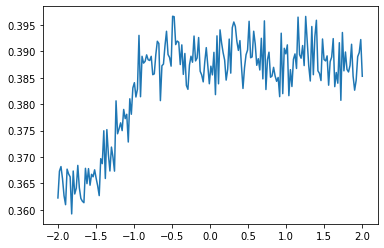

In [377]:
plt.plot(np.log10(lasso_df['alpha']), lasso_df['mse'])

In [378]:
alphavec = 10**np.linspace(-2,2,200)
y = yx_live['ip24_boe']

results_list = []

for alpha in alphavec:
    results_list.append([alpha,test_loop(X,y,150,model_obj=Lasso(alpha=alpha),scale=True)])

In [379]:
lasso_df = pd.DataFrame(results_list)
lasso_df[['test_r2','train_r2','mse']] = pd.DataFrame(lasso_df.iloc[:,1].values.tolist(), index= lasso_df.index)
lasso_df = lasso_df.drop([1],axis=1)
lasso_df.columns = ['alpha','test_r2','train_r2','mse']
print(lasso_df.head())
lasso_df.loc[lasso_df['mse'].idxmin()]

   alpha    test_r2  train_r2    mse
0  0.010  5.962e-03     0.036  0.049
1  0.010  3.129e-05     0.031  0.049
2  0.011 -6.790e-03     0.026  0.050
3  0.011 -8.650e-03     0.022  0.049
4  0.012 -1.508e-02     0.016  0.049


alpha       0.387
test_r2    -0.023
train_r2    0.000
mse         0.048
Name: 79, dtype: float64

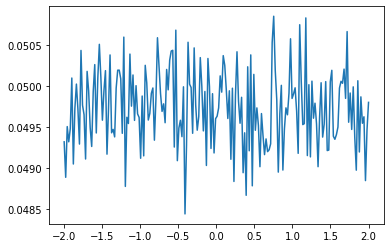

In [380]:
plt.plot(np.log10(lasso_df['alpha']), lasso_df['mse'])

In [414]:
X = yx_live.drop(['api_num','ip24_oil','ip24_gas',
                  'ip24_water','JobStartDate','CountyNumber',
                  'Latitude','Longitude','ip24_boe','sand'],axis=1)

y = np.log(yx_live['ip24_boe'])

coefs = split_and_validate(X,y,model_obj=Lasso(alpha=0.015),scale=True)['coef']

to_df = {'feature' : X.columns, 'coef' : coefs}
coef_df_lasso = pd.DataFrame(to_df)
coef_df_lasso[coef_df_lasso['coef'] == 0]

,feature,coef
3,ceramic-bool,0.0
5,100-mesh-bool,0.0
6,12/20-bool,0.0
7,16/30-bool,0.0
8,20/40-bool,0.0
9,30/50-bool,-0.0
10,40/140-bool,0.0
11,40/70-bool,0.0
13,acid,0.0
15,clay-bool,0.0


### Ridge

In [404]:
X = yx_live.drop(['api_num','ip24_oil','ip24_gas',
                  'ip24_water','JobStartDate','CountyNumber',
                  'Latitude','Longitude','ip24_boe','sand'],axis=1)
X = X.drop(coef_df_lasso[coef_df_lasso['coef'] == 0]['feature'],axis=1)
X.columns

Index(['ll', 'tvd', 'pressure', 'rcs-bool', 'other', 'biocide-bool', 'gel',
       'surfactant', 'total_base_vol', 'water_vol',
       'test_method_Gas Lift-bool'],
      dtype='object')

In [405]:
alphavec = 10**np.linspace(-2,2,200)
y = np.log(yx_live['ip24_boe'])

results_list = []

for alpha in alphavec:
    results_list.append([alpha,test_loop(X,y,150,model_obj=Ridge(alpha=alpha),scale=True)])

In [406]:
lasso_df = pd.DataFrame(results_list)
lasso_df[['test_r2','train_r2','mse']] = pd.DataFrame(lasso_df.iloc[:,1].values.tolist(), index= lasso_df.index)
lasso_df = lasso_df.drop([1],axis=1)
lasso_df.columns = ['alpha','test_r2','train_r2','mse']
print(lasso_df.head())
lasso_df.loc[lasso_df['mse'].idxmin()]

   alpha  test_r2  train_r2    mse
0  0.010    0.114     0.231  0.361
1  0.010    0.093     0.234  0.362
2  0.011    0.093     0.232  0.365
3  0.011    0.091     0.233  0.362
4  0.012    0.100     0.233  0.364


alpha       12.459
test_r2      0.118
train_r2     0.231
mse          0.351
Name: 154, dtype: float64

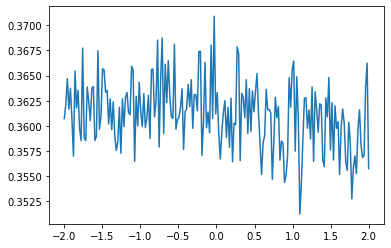

In [407]:
plt.plot(np.log10(lasso_df['alpha']), lasso_df['mse'])

In [497]:
X = yx_live.drop(['api_num','ip24_oil','ip24_gas',
                  'ip24_water','JobStartDate','CountyNumber',
                  'Latitude','Longitude','ip24_boe','sand'],axis=1)
X = X.drop(coef_df_lasso[coef_df_lasso['coef'] == 0]['feature'],axis=1)

y = np.log(yx_live['ip24_boe'])

final = split_and_validate(X,y,model_obj=Ridge(alpha=12.459),scale=True)
coefs = final['coef']

to_df = {'feature' : X.columns, 'coef' : coefs}
coef_df = pd.DataFrame(to_df)
coef_df['coef_adj'] = 10 ** coef_df['coef'] 
coef_df

,feature,coef,coef_adj
0,ll,-0.044,0.903
1,tvd,0.084,1.214
2,pressure,0.001,1.002
3,rcs-bool,0.020,1.046
4,other,-0.020,0.955
5,biocide-bool,-0.051,0.890
6,friction,0.033,1.079
7,gel,-0.105,0.785
8,total_base_vol,0.051,1.126
9,water_vol,-0.032,0.929


In [417]:
final

{'val_r2': 0.16904848176555842,
 'train_r2': 0.22951589611402523,
 'val_mse': 0.3484449726112378,
 'coef': array([-0.03186514,  0.07655757, -0.00459458,  0.02365909, -0.03189393,
        -0.04542649, -0.00425424, -0.10582848,  0.05700601, -0.02654576,
        -0.01248359,  0.01248359, -0.04573881,  0.02793378])}

### TVD Analysis

In [467]:
to_tvd_graphs = yx_live[['ip24_oil','tvd','total_base_vol','prop_total']]
to_tvd_graphs['fluid_bin'] = pd.cut(yx_live['total_base_vol'],4,labels=False)
to_tvd_graphs['fluid_bin_label'] = pd.cut(yx_live['total_base_vol'],4)
to_tvd_graphs['prop_bin'] = pd.cut(yx_live['prop_total'],4,labels=False)


/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/alexanderparker/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [468]:
to_tvd_graphs.head()

,ip24_oil,tvd,total_base_vol,prop_total,fluid_bin,fluid_bin_label,prop_bin
0,0.150,8426,1952.362,1610.858,1,"(1102.542, 1993.887]",1
1,0.072,7909,1405.218,1785.608,1,"(1102.542, 1993.887]",1
3,0.119,7288,2430.780,1701.221,2,"(1993.887, 2885.233]",1
4,0.067,7713,1126.563,1234.394,1,"(1102.542, 1993.887]",0
5,0.171,8091,1665.283,1605.994,1,"(1102.542, 1993.887]",1


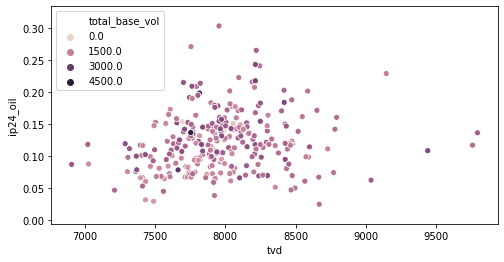

In [488]:
ax = plt.figure(figsize=(8, 4))

ax = sns.scatterplot(x="tvd", y="ip24_oil", hue="total_base_vol", data=to_tvd_graphs)

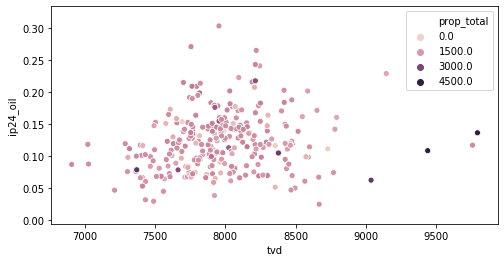

In [489]:
ax = plt.figure(figsize=(8, 4))

ax = sns.scatterplot(x="tvd", y="ip24_oil", hue="prop_total", data=to_tvd_graphs)

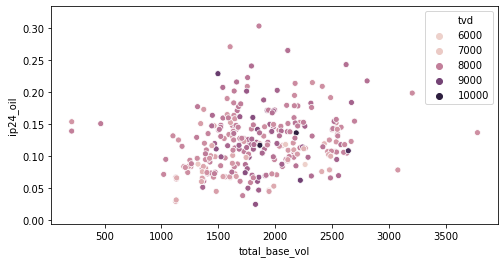

In [490]:
ax = plt.figure(figsize=(8, 4))

ax = sns.scatterplot(x="total_base_vol", y="ip24_oil", hue="tvd", data=to_tvd_graphs)

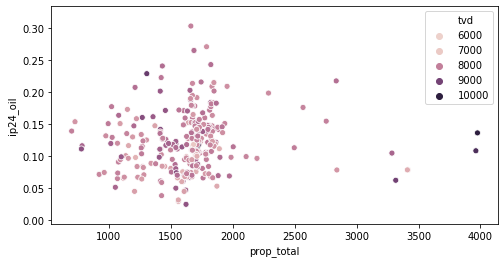

In [491]:
ax = plt.figure(figsize=(8, 4))

ax = sns.scatterplot(x="prop_total", y="ip24_oil", hue="tvd", data=to_tvd_graphs)

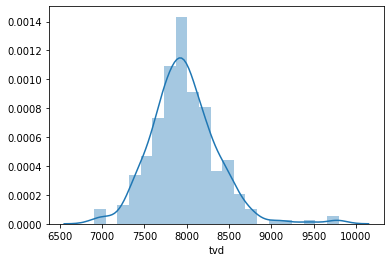

In [290]:
sns.distplot(yx_live['tvd'])

## Outputs

3622


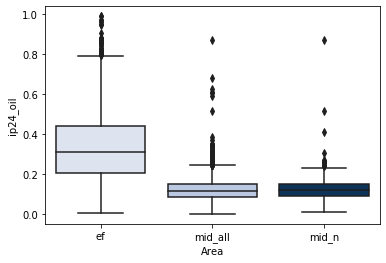

In [496]:
ef_pdf = table_clean(from_pickle('pickle/ef_pdfs.pickle')).dropna()
midland_all_pdfs = table_clean(from_pickle('pickle/midland_all_pdfs.pickle')).dropna()
midland_n_pdf = table_clean(from_pickle('pickle/n_midland_pdfs.pickle')).dropna()

def boxplot_prep(df,name):
    df['Area'] = name
    df['ip24_oil'] = df['ip24_oil'] / df['ll']
    return df 

ef_pdf = boxplot_prep(ef_pdf,'ef')
midland_all_pdfs = boxplot_prep(midland_all_pdfs,'mid_all')
midland_n_pdf = boxplot_prep(midland_n_pdf,'mid_n')

midland_n_pdf = midland_n_pdf[midland_n_pdf['ip24_oil'] < 1]
midland_all_pdfs = midland_all_pdfs[midland_all_pdfs['ip24_oil'] < 1]
ef_pdf = ef_pdf[ef_pdf['ip24_oil'] < 1]

print(len(midland_all_pdfs))

box_df = pd.concat([ef_pdf,midland_all_pdfs,midland_n_pdf]).reset_index(drop=True)

ax = sns.boxplot(x="Area", y="ip24_oil", data=box_df,palette= {'ef': '#DAE3F3','mid_n': '#003366','mid_all' : '#B4C7E7'})



In [447]:
box_df

,index,api_num,ip24_oil,ip24_gas,ip24_water,ll,tvd,pressure,comp_type,test_method,dataset
0,0,42255343990000,0.237,1315.0,857.0,4333.0,10311.0,3515.0,New Well,Flowing,ef
1,7,42255347890000,0.205,734.0,212.0,5978.0,10811.0,1883.0,Other/Recompletion,Flowing,ef
2,8,42255362520000,0.278,2058.0,1772.0,9131.0,11280.0,3741.0,New Well,Flowing,ef
3,13,42255349920000,0.556,3580.0,2884.0,3802.0,11011.0,3480.0,New Well,Flowing,ef
4,16,42255359230000,0.569,3543.0,2769.0,3476.0,10227.0,3445.0,New Well,Gas Lift,ef
5,17,42255352030000,0.623,6942.0,3954.0,8398.0,11080.0,3259.0,New Well,Flowing,ef
6,18,42255340190000,0.944,3599.0,3216.0,5140.0,11105.0,3462.0,New Well,Flowing,ef
7,20,42255358980000,0.319,2304.0,3637.0,6118.0,11807.0,3475.0,New Well,Gas Lift,ef
8,22,42255343980000,0.426,1060.0,1421.0,4351.0,10010.0,3515.0,New Well,Flowing,ef
9,23,42255348160000,0.175,1813.0,114.0,6432.0,12309.0,7830.0,New Well,Flowing,ef
